# 논문으로 알아보는 MGWR

[[LINK]](https://www.researchgate.net/publication/333694051_MGWR_A_Python_Implementation_of_Multiscale_Geographically_Weighted_Regression_for_Investigating_Process_Spatial_Heterogeneity_and_Scale) MGWR: A Python Implementation of Multiscale Geographically Weighted Regression for Investigating Process Spatial Heterogeneity and Scale 
<br></br>
Citation : Tobler, W.R. A Computer Movie Simulating Urban Growth in the Detroit Region

> Everything is related to everything else, but near things are more related than distant things

An ensemble of local linear models are calibrated at any number of locations by ‘borrowing’ nearby data.

A recent extension to the GWR framework allows each relationship in the model to vary at a unique spatial scale and is therefore known as multiscale (M)GWR. **MGWR is much less restrictive in its assumptions than GWR, since the relationship between the response and a covariate is allowed to vary locally, vary regionally, and or not vary at all.** Eliminating the restriction that all relationships vary at the same spatial scale can minimize over-fitting, reduce bias in the parameter estimates, and mitigate concurvity.

MGWR은 변수 특성을 감안한 조정된 밴드대역폭을 사용하여 보다 정밀하게 변수들 간의 공간관계를 설명할 수 있다. GWR을 발전시킨 방법으로 각 변수마다 같은 공간적인 대역폭을 사용하는 GWR에 반해서 각 변수마다 다른 대역폭을 사용하게 하여 변수 간의 공간적 자기상관관계를 나타낸다. 즉 데이터의 이웃으로 인식되는 범위를 나타내는 대역폭을 독립변수에 따라서 다르게 한다. 


## 모듈 설치 및 불러오기

In [ ]:
!pip install mgwr
!pip install pysal
!pip install geopandas

!pip install https://github.com/pysal/mgwr/archive/master.zip

In [52]:
import numpy as np
import pandas as pd
import libpysal as ps
import geopandas as gpd

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl

from spglm.family import  Poisson, Binomial

## EDA

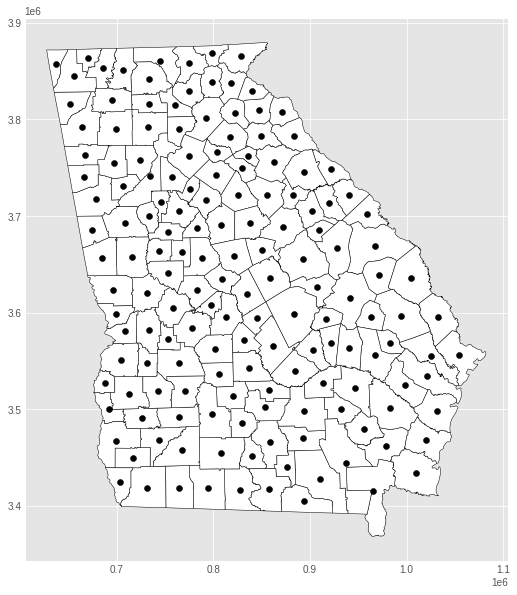

In [34]:
# Georgia data set
georgia = gpd.read_file(ps.examples.get_path('G_utm.shp'))
fig, ax = plt.subplots(figsize = (10, 10))

georgia.plot(ax = ax, **{'edgecolor' : 'black', 'facecolor' : 'white'})
georgia.centroid.plot(ax = ax, c = 'black')
plt.savefig('georgia_SHP')
plt.show()

Georgia 데이터셋

|Short Name|Description|
|----------------|------------------------|
|PctBach|Percentage of the population with a bachelor’s degree or higher|
|PctFB|Percentage of the population that was born in a foreign country|
|PctBlack|Percentage of the population that identifies as African American|
|PctRural|Percentage of the population that is classified as living in a rural area|

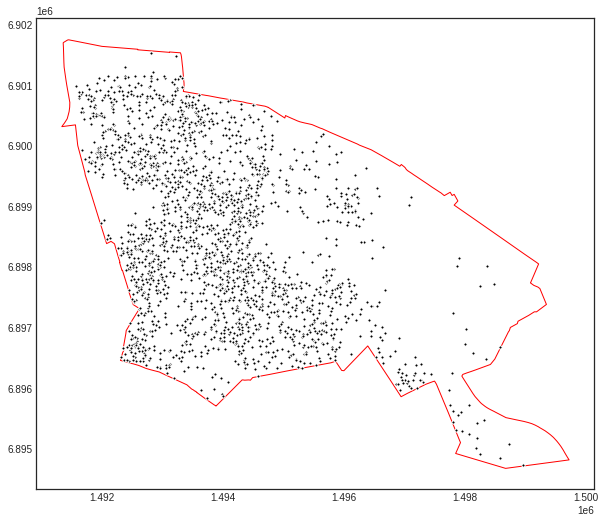

In [6]:
# Berlin data set

prenz = gpd.read_file(ps.examples.get_path('prenzlauer.zip'))
prenz_bound = gpd.read_file(ps.examples.get_path('prenz_bound.zip'))

fig, ax = plt.subplots(figsize = (10, 10))
prenz_bound.plot(ax = ax, **{'edgecolor' : 'red', 'facecolor' : 'white'})
prenz.plot(ax = ax, markersize = 10, **{'edgecolor' : 'white', 'facecolor' : 'black'})
plt.savefig('prenz')
plt.show()

Berlin 데이터셋

|Short Name|Description|
|-----------|----------------|
|Log price|Logged price of rental unit|
|Score|Cumulative review score from previous customers for each rental unit|
|Accommodates|Number of individuals a rental unit can accommodate|
|Bathrooms|Number of bathrooms in each rental unit|

## GWR Functionality

- GWR calibrates a separate regression model at each location through a data-borrowing scheme that distance-weights observations from each location serving as a regression point.

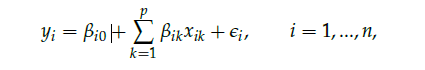

$y_i$ : 위치 $i$에 대한 독립적 변수
$\beta_{i0}$ : 위치 $i$에 대한 k번째 지역회귀계수
$\epsilon_i$ : $i$ 지역에 나타나는 무작위 랜덤값


**단, $i$는 반드시 좌표값으로 설정되어있어야함**

In [8]:
g_y = georgia['PctBach'].values.reshape((-1, 1))
g_X = georgia[['PctFB', 'PctBlack', 'PctRural']].values   ## 2D
u = georgia['X']
v = georgia['Y']

g_coords = list(zip(u, v))

In [9]:
# 가격변수의 왜곡을 수정하기위해 로그화

b_y = np.log(prenz['price'].values.reshape((-1, 1)))
b_x = prenz[['review_sco', 'accommodat', 'bathrooms']].values
u = prenz['X']
v = prenz['Y']

b_coords = list(zip(u, v))

### Distance-Weighting Scheme

#### Bandwidth Selection

대역폭에 대한 최적값찾기의 명시적인 매뉴얼이나 이론적 근거가 존재하지 않는다면 이 방법은 최선의 선택이 될 것이다. 

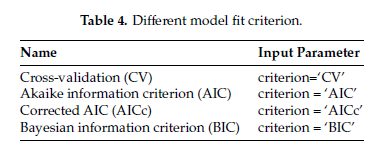




In [11]:
# Default golden search selection using AICc criterion
selector = Sel_BW(g_coords, g_y, g_X)
bw = selector.search()
print(bw)

117.0


In [13]:
# Interval search selection using AICc criterion
selector = Sel_BW(g_coords, g_y, g_X)
bw = selector.search(search_method = 'interval', interval = 2, bw_min = 101, bw_max = 150)
print(bw)

117


#### Model Calibration

1. GWR model을 통해 인스턴트화
2. Fitting (model 함수 불러오기)

가장 중요한 input은 bandwidth parameter(bandwidth selection으로 최적화 가능)으로 GWR 연산에 반드시 명시되어있어야 한다.


In [21]:
# Calibrate a GWR model using computationally selected bandwidth
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

gwr_model = GWR(g_coords, g_y, g_X, bw = gwr_bw, kernel = 'bisquare')
gwr_result = gwr_model.fit()
# 잔차제곱합(RSS, Residuals sum of square)
print(gwr_result.resid_ss)
# R2 = 67.8% 만큼의 설명력
print(gwr_result.R2)

117.0
1650.8596982770284
0.6780742669593463


In [22]:
# 또한 bandwidth는 직접 설정하여 GWR model을 계산할 수 있다.
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

gwr_model = GWR(g_coords, g_y, g_X, 117)
gwr_result = gwr_model.fit()
print(gwr_result.resid_ss)

117.0
1650.8596982770284


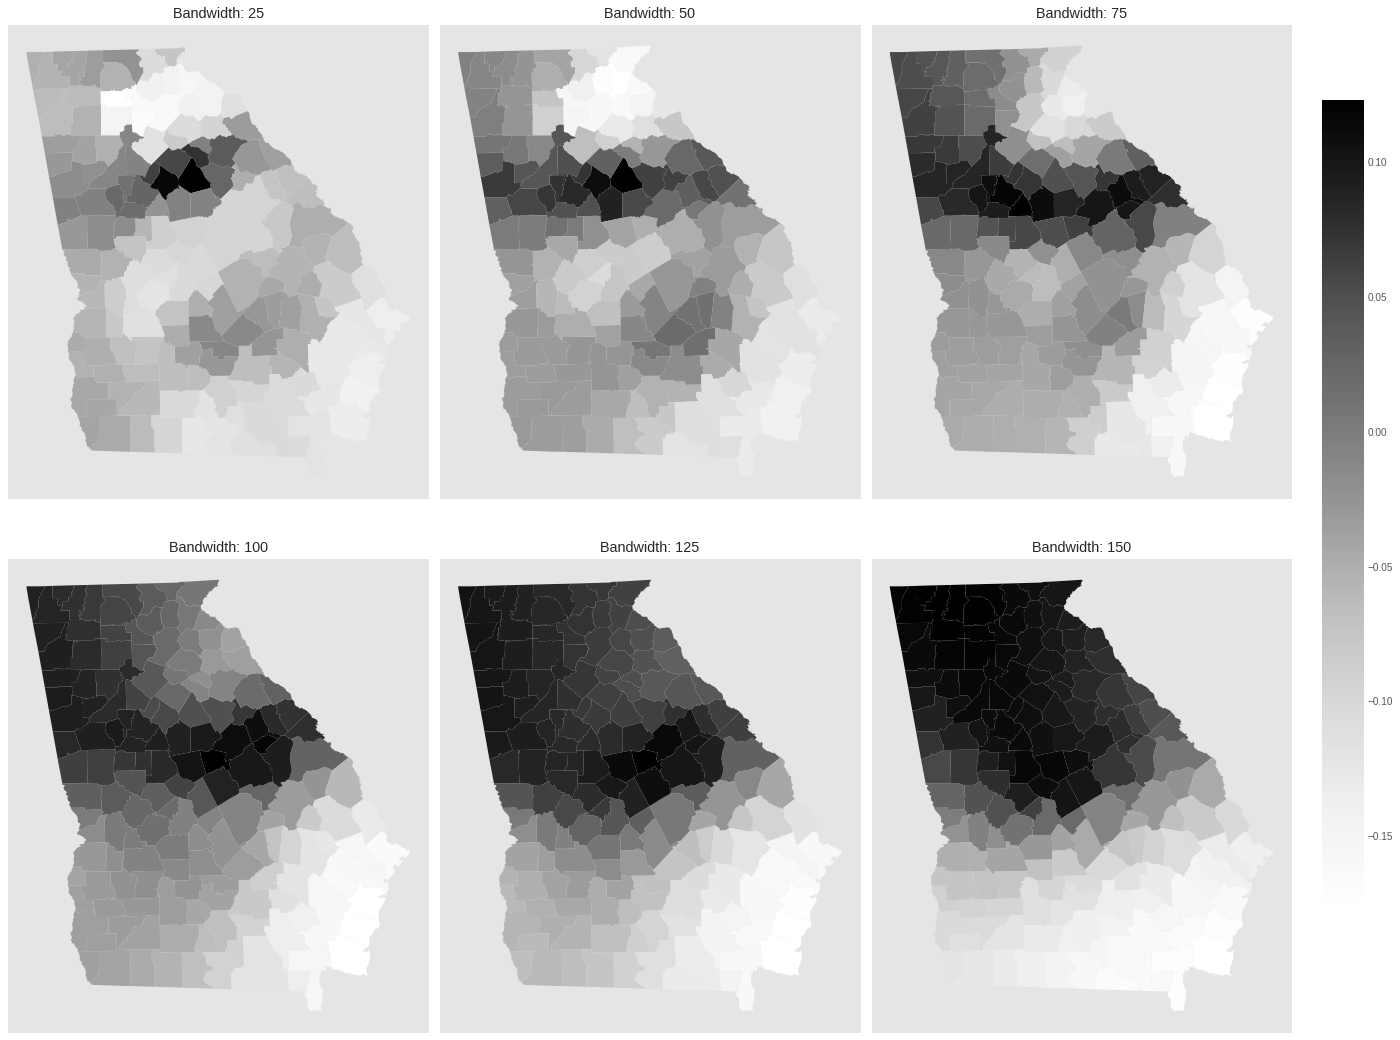

In [33]:
# 공간이질성(spatial heterogeneity)을 다양한 bandwidth를 적용해가면서 탐색
## 공간이질성이 나타나는 이유는 공간현상이 모든 지역에서 균등하게 나타나는것이 아니라 지역 내 하부지역에 따라 각기 다른 특성을 나타내기 때문이다. 
## 중심지와 배후지역의 존재, 선도지역과 낙후지역의 존재 등이 공간이질성의 대표적인 예라고할수있다

fig, ax = plt.subplots(2, 3, figsize = (20, 15))
bws = (x for x in range(25, 175, 25))

vmins = []
vmaxs = []

for row in range(2):
  for col in range(3):
    bw = next(bws)
    gwr_model = GWR(g_coords, g_y, g_X, bw)
    gwr_result = gwr_model.fit()

    georgia['rural'] = gwr_result.params[:, -1]
    georgia.plot('rural', ax = ax[row, col])
    ax[row, col].set_title('Bandwidth: ' + str(bw))
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)

    vmins.append(georgia['rural'].min())
    vmaxs.append(georgia['rural'].max())

sm = plt.cm.ScalarMappable(norm = plt.Normalize(vmin = min(vmins), vmax = max(vmaxs)))
fig.tight_layout()
fig.subplots_adjust(right = .9)

cax = fig.add_axes([.92, .14, .03, .75])
sm._A = []

cbar = fig.colorbar(sm, cax = cax)
cbar.ax.tick_params(labelsize = 10)

plt.show()


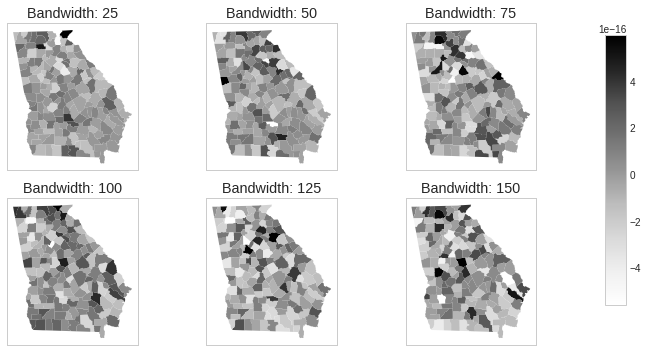

In [38]:
# Binomial logistic GWR, Poisson GWR로 연산 가능
family_Poission = Poisson()
family_Binomial = Binomial()

fig, ax = plt.subplots(2, 3, figsize = (10, 5))
bws = (x for x in range(25, 175, 25))

vmins = []
vmaxs = []

for row in range(2):
  for col in range(3):
    bw = next(bws)
    gwr_model = GWR(g_coords, g_y, g_X, bw, family = family_Binomial)
    gwr_result = gwr_model.fit()

    georgia['rural'] = gwr_result.params[:, -1]
    georgia.plot('rural', ax = ax[row, col])
    ax[row, col].set_title('Bandwidth: ' + str(bw))
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)

    vmins.append(georgia['rural'].min())
    vmaxs.append(georgia['rural'].max())

sm = plt.cm.ScalarMappable(norm = plt.Normalize(vmin = min(vmins), vmax = max(vmaxs)))
fig.tight_layout()
fig.subplots_adjust(right = .9)

cax = fig.add_axes([.92, .14, .03, .75])
sm._A = []

cbar = fig.colorbar(sm, cax = cax)
cbar.ax.tick_params(labelsize = 10)

plt.show()

#### 모델 진단

1. Model Fit
- 범용적인 통계방식인 AIC, AICc, pseudo-R2 값들을 통해 모델을 평가할 수 있다. 또한, 지역적 R2 통계값을 맵핑함으로써 각각의 calibration에 대한 모델의 fit값을 평가할 수 있다.

Figure 6 shows that the individual regression models that comprise the GWR model have model fits that are both larger and smaller than the global R2. It is also clear that the variation in model fit is spatially patterned with higher model fit in the north than in the south.

In [40]:
# Global model fit
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_result = gwr_model.fit()
print(gwr_result.aic)
print(gwr_result.aicc)
print(gwr_result.R2)

117.0
848.9154070534352
851.3502927844658
0.6780742669593463


<Figure size 720x360 with 0 Axes>

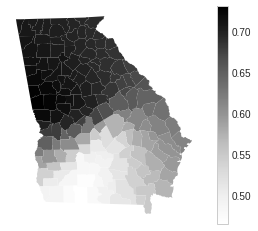

In [44]:
# 국지적 모델 Fitting

georgia['R2'] = gwr_result.localR2
georgia.plot('R2', legend = True)

plt.axis(False)

plt.show()

117.0


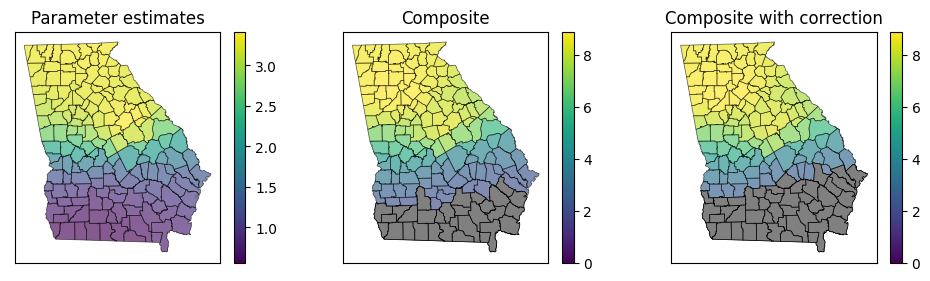

In [53]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_result = gwr_model.fit()


# 디폴트값
filter_tc = gwr_result.filter_tvals()
# 수정 없이 일반적인 alpha값을 사용
filter_t = gwr_result.filter_tvals(alpha = .05)

# set
georgia['fb'] = gwr_result.params[:, 1]
georgia['fb_tc'] = filter_tc[:, 1]
georgia['fb_t'] = filter_t[:, 1]


# Plotting
fig, ax = plt.subplots(1, 3, figsize = (12, 3))

georgia.plot('fb', **{'edgecolor' : 'black', 'alpha' : .65, 'linewidth' : .5}, ax = ax[0], legend = True)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Parameter estimates")

georgia.plot('fb_t', **{'edgecolor' : 'black', 'alpha' : .65, 'linewidth' : .5}, ax = ax[1], legend = True)
georgia[filter_t[:, 1] == 0].plot(color = 'grey', ax = ax[1], **{'edgecolor' : 'black', 'linewidth' : .5})
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Composite")

georgia.plot('fb_tc', **{'edgecolor' : 'black', 'alpha' : .65, 'linewidth' : .5}, ax = ax[2], legend = True)
georgia[filter_tc[:, 1] == 0].plot(color = 'grey', ax = ax[2], **{'edgecolor' : 'black', 'linewidth' : .5})
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[2].set_title("Composite with correction")

plt.show()